In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(   num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('../content/drive/MyDrive/Colab Notebooks/neyro/sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2022-04-27 12:05:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2022-04-27 12:05:35 (77.6 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [5]:
corpus[:15]

['the sonnets',
 '',
 'by william shakespeare',
 '',
 '',
 '',
 '',
 '  i',
 '',
 '  from fairest creatures we desire increase,',
 "  that thereby beauty's rose might never die,",
 '  but as the riper should by time decease,',
 '  his tender heir might bear his memory:',
 '  but thou, contracted to thine own bright eyes,',
 "  feed'st thy light's flame with self-substantial fuel,"]

In [6]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [7]:
label.shape

(15485, 3383)

In [8]:
#Создаем сеть
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранний останов"

In [25]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
#model.add(Dense(total_words, activation = 'softmax'))
#model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 256)           866048    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1691)              434587    
                                                                 
 dense_10 (Dense)            (None, 3383)              5724036   
                                                                 
Total params: 7,549,983
Trainable params: 7,549,983
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
 history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
388/388 [==============================] - 9s 17ms/step - loss: 7.0925 - accuracy: 0.0223 - val_loss: 6.7427 - val_accuracy: 0.0165
Epoch 2/100
388/388 [==============================] - 6s 15ms/step - loss: 6.4849 - accuracy: 0.0244 - val_loss: 6.9009 - val_accuracy: 0.0184
Epoch 3/100
388/388 [==============================] - 6s 15ms/step - loss: 6.3773 - accuracy: 0.0259 - val_loss: 7.0259 - val_accuracy: 0.0226
Epoch 4/100
388/388 [==============================] - 6s 15ms/step - loss: 6.2576 - accuracy: 0.0350 - val_loss: 7.1261 - val_accuracy: 0.0358
Epoch 5/100
388/388 [==============================] - 6s 15ms/step - loss: 6.1154 - accuracy: 0.0406 - val_loss: 7.2278 - val_accuracy: 0.0239
Epoch 6/100
388/388 [==============================] - 6s 15ms/step - loss: 5.9928 - accuracy: 0.0441 - val_loss: 7.4290 - val_accuracy: 0.0255
Epoch 7/100
388/388 [==============================] - 6s 15ms/step - loss: 5.8694 - accuracy: 0.0482 - val_loss: 7.5763 - val_accuracy:

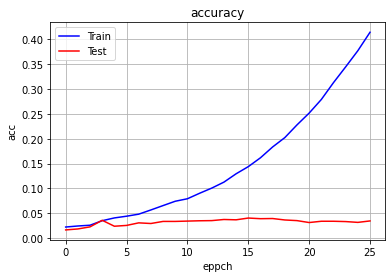

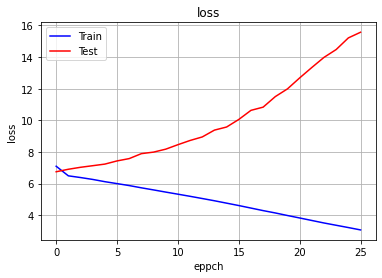

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "machine learning is true"
next_words = 10
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
  predicted = model.predict(token_list, verbose=0)
  predict_ = np.argmax(predicted)
  output_word = ""
  print(predict_)
  # добавим новое слово в последовательность
  for word, index in tokenizer.word_index.items():
    if index == predict_:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[590, 17, 4, 351, 388]
36
[590, 17, 4, 351, 388, 36]
395
[590, 17, 4, 351, 388, 36, 395]
135
[590, 17, 4, 351, 388, 36, 395, 135]
126
[590, 17, 4, 351, 388, 36, 395, 135, 126]
154
[590, 17, 4, 351, 388, 36, 395, 135, 126, 154]
71
[590, 17, 4, 351, 388, 36, 395, 135, 126, 154, 71]
4
[590, 17, 4, 351, 388, 36, 395, 135, 126, 154, 71, 4]
15
[590, 17, 4, 351, 388, 36, 395, 135, 126, 154, 71, 4, 15]
32
[590, 17, 4, 351, 388, 36, 395, 135, 126, 154, 71, 4, 15, 32]
323
Help me Obi Wan Kenobi, you're my only hope or steal there made ' still my love doth sing


Помоги мне, Оби Ван Кеноби, ты моя единственная надежда, или укради там, что сделано, и моя любовь все еще поет.

In [29]:
y_p=model.predict(token_list)

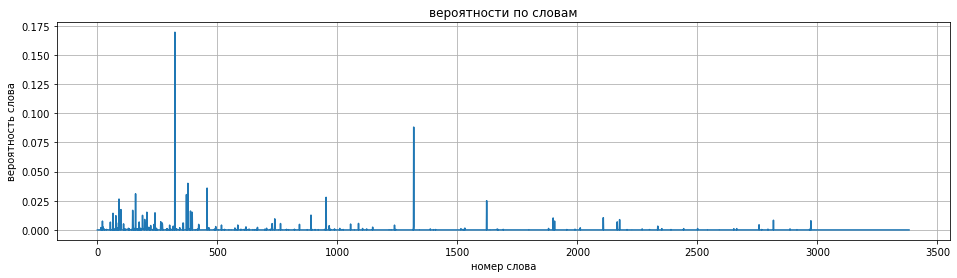

In [30]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [31]:
ind_prob=np.where(y_p[0,:]>0.028)[0]
ind_prob

array([ 159,  323,  371,  377,  457, 1318])

In [32]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

find  :  0.030962527
sing  :  0.16939397
go  :  0.030278413
read  :  0.039914925
truly  :  0.035839234
strive  :  0.08812099


In [33]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p = model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[590, 17, 4, 351, 388]
[590, 17, 4, 351, 388, 36]
[590, 17, 4, 351, 388, 36, 198]
[590, 17, 4, 351, 388, 36, 198, 4]
[590, 17, 4, 351, 388, 36, 198, 4, 221]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23, 67]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23, 67, 220]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23, 67, 220, 191]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23, 67, 220, 191, 159]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23, 67, 220, 191, 159, 17]
[590, 17, 4, 351, 388, 36, 198, 4, 221, 184, 154, 22, 23, 67, 220, 191, 159, 17, 78]
Help me Obi Wan Kenobi, you're my only hope or die my end friend ' as all one happy heaven find me am in


Помоги мне, Оби Ван Кеноби, ты моя единственная надежда, или умри, мой последний друг", как все счастливые небеса находят меня в

При увеличении количества слоев сети происходит переобучение и сильно выростает ошибка.

Улучшение качества происходит при небольшом увеличении нейронов